In [2]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import mylib as my
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats

import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations


In [2]:
my.set_atlas_style('large')
############# Dati in imput #######################################
dataSelection = 'LAB'
runI = [730]
#runI = 340 
runI = [758, 759, 760, 761, 762, 730, 731, 732, 733, 734]
runI = [823] 
for nRi in xrange(0,len(runI)):
    #############  Genera imagine di fondo ############################
    max_image=np.size([f for f in os.listdir(cy.file2FullPathCygnus(dataSelection, runI[nRi], 'H5')) if not f.startswith('.')])
    print ("# of Image Files: %d" % (max_image))
    
    # Usa la prima imagine cone BCK e non la usa per l'analisi
    N = 10.0
    img_save = my.read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[nRi], 0)) 
    if N>1:
        for i in range(0, int(N)):
            dataImage = my.read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[nRi], i))
            img_save = np.copy((dataImage+(N-1)*img_save)/N)
    
    ################ Parametri di analisi ################################
    cimin, cimax = 101, 150  # valori del cut sull'imagine
    iTr          = 10         # traccia di partenza
    rescale      = 128       # binnagio finale immagine (deve essre un sottomultipli della 2**2 risluzione di partenza)
    minClose     = 5         # minima dimesione del cluster (nel rebin)
    maxClose     = 300       # massima dimesione del clustr evita le scriche
    thC          = 2.        # vicinanza dei pixel nel cluster
    pixelCut     = 0        
    
    ############### Inzializzazione varibili e costanti #################
    scale  = (dataImage.shape[1]/rescale)
    data   = []
    debug  = True
    yy0    = np.arange(0, rescale)
    col    = ('b.', 'r.', 'c.', 'm.', 'y.', 'k.', 'g.') # sostituire g con k se si vogliono anche i singoli
    hL     = my.Hist1D(200, 6000, 8000)
    hB     = my.Hist1D(200, 6000, 8000)
    hP     = my.Hist1D(scale*scale, 0, scale*scale)
    hLP    = my.Hist1D(300, 80, 380)
    hBP    = my.Hist1D(300, 80, 380)
    hLBP   = my.Hist1D(60, -30, 30)
    hLS    = my.Hist1D(cimax-cimin, cimin, cimax)
    hLBPS  = my.Hist1D(100, -20, 30)
    hLBPSe = my.Hist1D(100, -20, 80)
    hLBPSg = my.Hist1D(100, -20, 80)
    hLBPSn = my.Hist1D(100, -20, 80)
    luceB = my.Hist1D(100, 0, 1000)
    #hLBPSe = my.Hist1D(100, 80, 180)
    #hLBPSg = my.Hist1D(100, 80, 180)
    #hLBPSn = my.Hist1D(100, 80, 180)
    ###############
    while True:
        try:
    
            t0 = time.time()
            bad       = False
            dataImage = my.read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[nRi], iTr)) 
            rowEdges  = (dataImage > cimin) & (dataImage < cimax)
            imgRes    = my.rebin(dataImage, (rescale, rescale))
            edges     = (imgRes > cimin) & (imgRes < cimax)            # soglia del contenuto dei pixel
            points    = np.array(np.nonzero(edges)).T.astype(float)    # NB RANSCAN vuole float!
                                                                       # x, y = np.where(edges)
                                                                       # points = np.column_stack([float(x), float(y)])
            if dataImage.sum()<43e7:
                #plt.imshow(dataImage, cmap="gray", vmin=85,vmax=150)
                C = my.NNClustering(points, thC)
                dCloseT, iCloseT, infoCloseT = my.NNClusteringInfo(C)
                if dCloseT < maxClose:
                    TrOk=0
                    poiE = []
                    poiG = []
                    poiN = []
                    for Ci in xrange (0, len(infoCloseT)):
                        pClose = len(infoCloseT[Ci])
                        if minClose <= pClose:
                            luceOn = luceOff = pixelS =  0.0
    
                            for i in xrange(0, pClose):
                                x0   = int(C[infoCloseT[Ci]][i,2])*scale
                                y0   = int(C[infoCloseT[Ci]][i,3])*scale
                                #plt.plot(x0, y0, 'g.', markersize=1)
                                nPixel  = rowEdges[(y0+pixelCut):(y0+scale+pixelCut),
                                                    (x0+pixelCut):(x0+scale+pixelCut)].sum()
                                sLuce   = dataImage[(y0+pixelCut):(y0+scale+pixelCut),
                                                    (x0+pixelCut):(x0+scale+pixelCut)].sum()
                                bLuce   = img_save[(y0+pixelCut):(y0+scale+pixelCut),
                                                    (x0+pixelCut):(x0+scale+pixelCut)].sum()
                                
                                pixelS  = pixelS + nPixel
                                luceOn  = luceOn + sLuce
                                luceOff = luceOff + bLuce
                                phm = (sLuce-bLuce)/nPixel
                                hL.fill(sLuce)
                                hB.fill(bLuce)
                                hP.fill(nPixel)     
                                hLP.fill(sLuce/nPixel) 
                                hBP.fill(bLuce/nPixel) 
                                hLBP.fill(phm)
                                if debug:
                                    print iTr, TrOk, sLuce, bLuce, nPixel, sLuce/nPixel, (sLuce-bLuce)/nPixel
                            ph_media = (luceOn-luceOff)/pixelS
                            luceB.fill(luceOn-luceOff)
                            if debug:
                                print TrOk, ph_media, pClose, ph_media*pClose*scale*scale, luceOn-luceOff
                            for i in xrange(0, pClose):
                                x0   = int(C[infoCloseT[Ci]][i,2])*scale
                                y0   = int(C[infoCloseT[Ci]][i,3])*scale
                                for ny in range (y0, y0+scale):
                                    for nx in range (x0, x0+scale):
                                        if rowEdges[ny, nx]:
                                            hLS.fill(dataImage[ny, nx])
                                            ph = dataImage[ny, nx]-img_save[ny, nx]
                                            hLBPS.fill(ph)
                                            if     ph_media <=3:
                                                
                                                hLBPSe.fill(ph)
                                                if debug:
                                                    poiE.append([nx,ny])
                                            if 3 < ph_media <=5:
                                                hLBPSg.fill(ph)
                                                if debug:
                                                    poiG.append([nx,ny])
    #                                        if    ph_media > 2:
    #                                            hLBPSg.fill(ph)
    #                                            if debug:
    #                                                poiG.append([nx,ny])
    
                                            if     ph_media > 5:
                                                hLBPSn.fill(ph)
                                                if debug:
                                                    poiN.append([nx,ny])
    #                                                
    #                                        if     pClose > 5:
    #                                            hLBPSn.fill(ph)
    #                                            if debug:
    #                                                poiN.append([nx,ny])
    
    
                            #distances = [my.PointDist(p1, p2) for p1, p2 in combinations(points, 2)]
                            #avg_distance = sum(distances) / len(distances)
                            data.append([iTr, TrOk, luceOn, luceOff, pixelS, pClose])
                            TrOk+=1
                else:
                    print ('>>> Imagine not anayzed: %d, Tracce: %d, luce: %d Clustering: %d' % 
                                      (iTr, TrOk,  dataImage.sum(), dCloseT))
                    bad   = True
            else:
                print ('>>> Imagine not Clastered: %d, Tracce: %d, luce: %d' % 
                                      (iTr, TrOk,  dataImage.sum()))
                bad   = True
                
        
            if debug:
                print ("Cluster Size: %d" % (dCloseT))
                fig, ax = plt.subplots(2,2)
                ax[0,0].imshow(dataImage, cmap="gray", vmin=85,vmax=150)
                ax[0,0].set_title("I%d Run%d" % (iTr, runI[nRi]))
                ax[0,1].imshow(edges, cmap="gray", vmin=0,vmax=1)
                ax[0,1].plot(points[:,1], points[:,0], 'g.', markersize=10)
                NCL  = 0
                ncol = 0
                for i in xrange(0, len(C)):
                    if C[i,1]>0:
                        if C[i,1]==1:
                            NCL +=1
                            ncol +=1
                            if ncol>6:
                                ncol = 0
                            ax[0,1].annotate(("%d"%(NCL)), (C[i,2]+1, C[i,3]+1), color='white', size=15)
                        ax[0,1].plot(C[i-1,2], C[i-1,3], col[ncol], markersize=5)
                        ax[0,1].plot(C[i,2], C[i,3], col[ncol], markersize=5)
                #ax[1,0].step(*hLS.data)
                ax[1,0].imshow(dataImage, cmap="gray", vmin=85,vmax=150)
                poiE = np.array(poiE)
                poiG = np.array(poiG)
                poiN = np.array(poiN)
    
                if poiE.any():
                    ax[1,0].plot(poiE[:,0], poiE[:,1], 'y.', markersize=1)
                if poiG.any():
                    ax[1,0].plot(poiG[:,0], poiG[:,1], 'g.', markersize=1)
                if poiN.any():
                    ax[1,0].plot(poiN[:,0], poiN[:,1], 'r.', markersize=1)
                #ax[1,1].step(*hLBPS.data)
                #ax[1,1].step(*hLBPSe.data)
                #ax[1,1].step(*hLBPSg.data)
                #ax[1,1].step(*hLBPSn.data)
                ax[1,1].step(*luceB.data)
                # resetta i grafici in caso del solo debug per l'anlisi imagine per imagine
                hLS    = my.Hist1D(cimax-cimin, cimin, cimax)
                #hLBPS  = my.Hist1D(100, 80, 180)
                hLBPS  = my.Hist1D(100, -20, 30)
                #hLBPSe = my.Hist1D(100, 80, 180)
                #hLBPSg = my.Hist1D(100, 80, 180)
                #hLBPSn = my.Hist1D(100, 80, 180)
                hLBPSe = my.Hist1D(100, -20, 80)
                hLBPSg = my.Hist1D(100, -20, 80)
                hLBPSn = my.Hist1D(100, -20, 80)
                luceB = my.Hist1D(100, 0, 1000)
            if iTr/10.0 == int(iTr/10.0):
                print ('Imagine: %d, Tracce: %d, luce: %d bck: %d' % 
                       (iTr, TrOk,  dataImage.sum(), img_save.sum()))
            plt.show()
            if debug:
                display.display(plt.show())
                display.clear_output(wait=True)
        
            if iTr == max_image-1:
                break
            iTr+=1
            #
            if not bad:   
                img_save = np.copy((dataImage+(N-1)*img_save)/N)
                bad = False
            if debug:
                raw_input('Press <ret> to continue -> ')
            print ("Dt: %.2e, %d, %d, %d, %d"% (time.time()-t0, luceOn, luceOff, pixelS, pClose))
        except KeyboardInterrupt:
            break
    files = ("./data/clustering_run%d_cut_%d-%d_scale_%d_close_%d.txt" % (runI[nRi], cimin, cimax, scale, minClose))
    np.savetxt(files, data, fmt='%.10e', delimiter=" ")
    print ("ENDED - Out on File: %s" % files)
    data=np.array(data)
        # with open(("./data/neutron_run%d_cut_%d-%d_scale_%d.txt" % 
        #           (runI[nRi], cimin, cimax, scale)), 'wb') as fp:
        #    pickle.dump(data, fp)
    

ENDED - Out on File: ./data/clustering_run340_cut_101-150_scale_16_close_5.txt


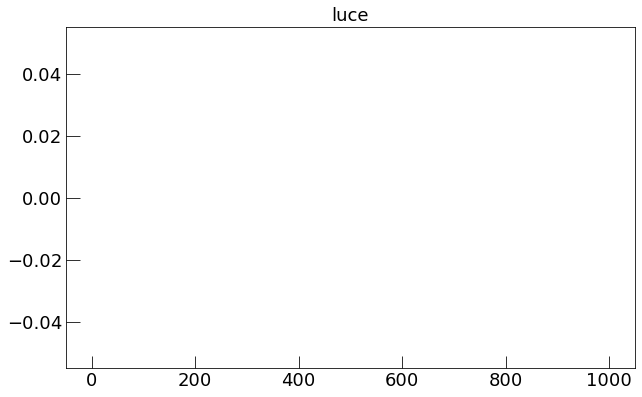

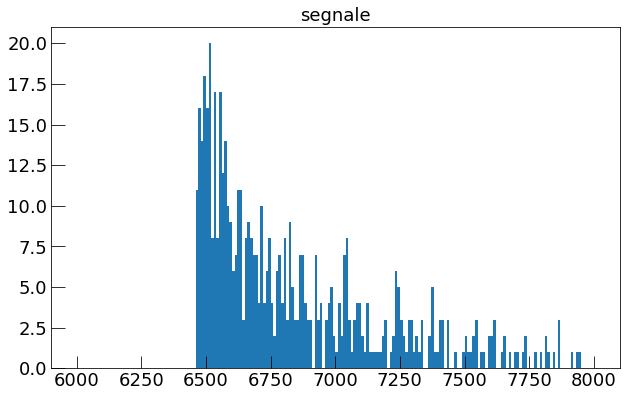

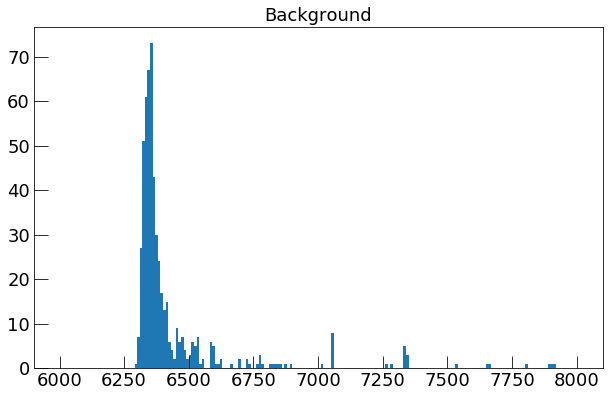

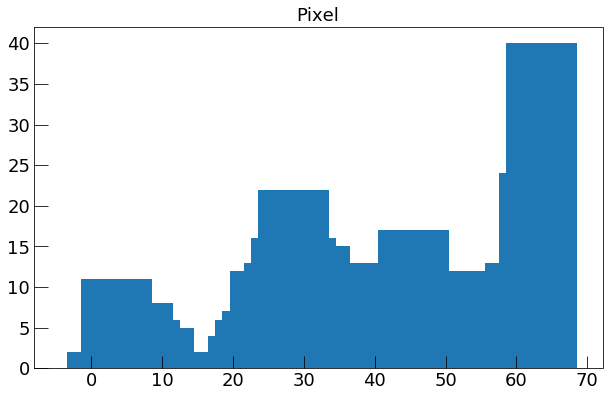

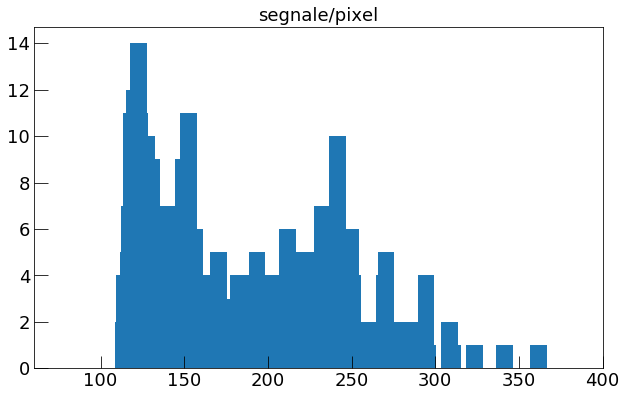

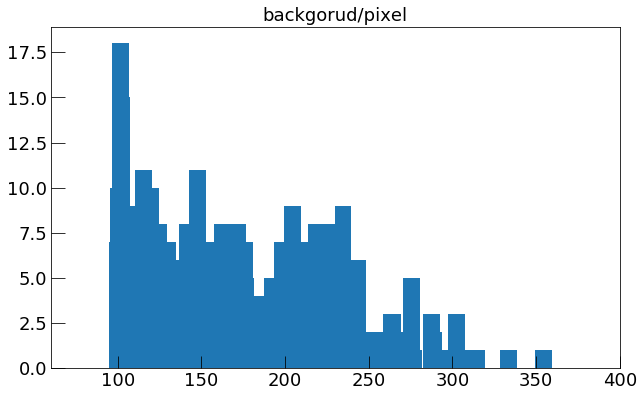

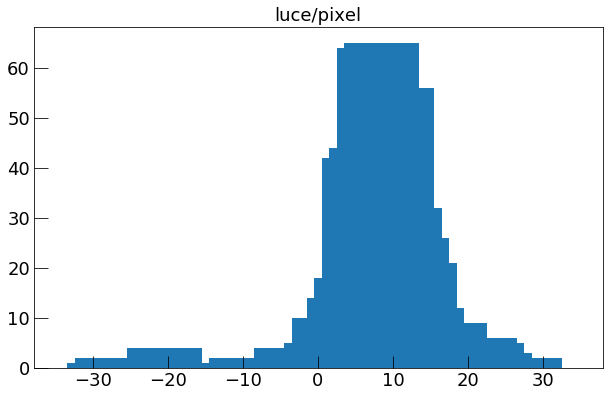

In [9]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from scipy.stats import norm
my.set_atlas_style()
y        = np.array(luceB.data[1])
x        = np.array(luceB.data[0])

plt.bar(x,y, 10, align='center')
plt.title("luce")
plt.show()
y        = np.array( hL.data[1])
x        = np.array( hL.data[0])

plt.bar(x,y, 10, align='center')
plt.title("segnale")
plt.show()
plt.show()
y        = np.array( hB.data[1])
x        = np.array( hB.data[0])

plt.bar(x,y, 10, align='center')
plt.title("Background")
plt.show()
y        = np.array( hP.data[1])
x        = np.array( hP.data[0])

plt.bar(x,y, 10, align='center')
plt.title("Pixel")
plt.show()
y        = np.array( hLP.data[1])
x        = np.array( hLP.data[0])

plt.bar(x,y, 10, align='center')
plt.title("segnale/pixel")
plt.show()
plt.show()
y        = np.array( hBP.data[1])
x        = np.array( hBP.data[0])

plt.bar(x,y, 10, align='center')
plt.title("backgorud/pixel")
plt.show()

y        = np.array( hLBP.data[1])
x        = np.array( hLBP.data[0])

plt.bar(x,y, 10, align='center')
plt.title("luce/pixel")
plt.show()


In [ ]:
points[0,3]